# Nested ANOVA - one between factor
Reference: http://www.flutterbys.com.au/stats/tut/tut9.2b.html

In [1]:
import pandas as pd
import numpy as np
 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pymc3 as pm
import patsy

C:\Miniconda3\envs\GLM_with_PyMC3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Data loading

In [2]:
#curdies = pd.read_csv('../datasets/curdies.csv', na_values=0)
curdies = pd.read_csv('../datasets/curdies.csv')
curdies.head()

,SEASON,SITE,DUGESIA,S4DUGES
0,WINTER,1,0.647683,0.897100
1,WINTER,1,6.096152,1.571317
2,WINTER,1,1.310564,1.069953
3,WINTER,1,1.725279,1.146080
4,WINTER,1,1.459387,1.099114


In [3]:
labels_SITE = ['{}{}'.format(curdies['SITE'][i], curdies['SEASON'][j][0]) for i, j in zip(curdies['SITE'].index, curdies['SEASON'].index)]
labels_SITE = sorted(list(set(labels_SITE)))
labels_SITE

['1W', '2W', '3W', '4S', '5S', '6S']

In [4]:
#curdies.dropna(axis=0, inplace=True)
#curdies.reset_index(inplace=True)
curdies.head()

,SEASON,SITE,DUGESIA,S4DUGES
0,WINTER,1,0.647683,0.897100
1,WINTER,1,6.096152,1.571317
2,WINTER,1,1.310564,1.069953
3,WINTER,1,1.725279,1.146080
4,WINTER,1,1.459387,1.099114


In [5]:
curdies['SEASON'] = pd.Categorical(curdies['SEASON'].apply(lambda x: x.strip()), categories=['WINTER', 'SUMMER'], ordered=True)
curdies['SITE'] = pd.Categorical(curdies['SITE'], ordered=False)
curdies['SITE'].cat.rename_categories(labels_SITE, inplace=True)
curdies.head(10)

,SEASON,SITE,DUGESIA,S4DUGES
0,WINTER,1W,0.647683,0.897100
1,WINTER,1W,6.096152,1.571317
2,WINTER,1W,1.310564,1.069953
3,WINTER,1W,1.725279,1.146080
4,WINTER,1W,1.459387,1.099114
5,WINTER,1W,1.057561,1.014090
6,WINTER,2W,1.016298,1.004050
7,WINTER,2W,16.196794,2.006122
8,WINTER,2W,1.168081,1.039605
9,WINTER,2W,1.024299,1.006020


In [6]:
curdies_agg = curdies.groupby(by=['SEASON', 'SITE'], as_index=False).mean()
curdies_agg.dropna(axis=0, inplace=True)
curdies_agg.reset_index(inplace=True)
curdies_agg

,index,SEASON,SITE,DUGESIA,S4DUGES
0,0,WINTER,1W,2.049437,1.132942
1,1,WINTER,2W,4.181908,1.271870
2,2,WINTER,3W,0.678206,0.867871
3,9,SUMMER,4S,0.419095,0.350821
4,10,SUMMER,5S,0.229086,0.180462
5,11,SUMMER,6S,0.194244,0.381122


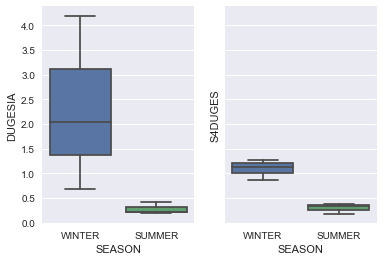

In [7]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)

sns.boxplot(data=curdies_agg, x='SEASON', y='DUGESIA', ax=ax[0]) # variance is non heterogeneous
sns.boxplot(data=curdies_agg, x='SEASON', y='S4DUGES', ax=ax[1]) # the 4th root transformation helps at making the variance heterogeneous

## Fit hierarchical model
I will use the matrix parametrization

In [8]:
#X = patsy.dmatrix('SEASON', data=curdies_agg, return_type='dataframe')
#X # the size should be (n_sites, n_seasons), that is the number of row should be equal to the number of random factors
X = patsy.dmatrix("SEASON", data=curdies, return_type='dataframe')
X = np.asarray(X)
X

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.]])

In [9]:
# Random effect on the intercepts
Z = patsy.dmatrix('-1 + SITE', data=curdies, return_type='dataframe')
Z = np.asarray(Z)

In [10]:
Y = np.asarray(curdies.S4DUGES)
Y

array([0.8970995, 1.5713175, 1.0699526, 1.1460797, 1.0991136, 1.0140897,
       1.0040498, 2.0061216, 1.0396048, 1.0060202, 1.1908882, 1.3845343,
       0.9111253, 1.0507807, 1.0271582, 0.9002881, 0.6074385, 0.7104333,
       0.       , 0.       , 0.9849349, 0.       , 0.       , 1.1199931,
       1.0827734, 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.6037669, 0.       , 0.9006648, 0.7823021])

In [11]:
with pm.Model() as model:
    
    ## Priors
    # SEASON (2 levels)
    # The values split on season have the same variance (see boxplot above)
    
    # Coefficients for WINTER and SUMMER
    beta_X = pm.Normal('beta_X', mu=0, sd=50, shape=X.shape[1])
    
    estimate_X = pm.math.dot(X, beta_X)
     
    # SITE (6 levels)
    # There are 6 different sites, 3 within SEASON
    sigma_Z = pm.HalfCauchy('sigma_Z', beta=3)
    
    # Centered version
    gamma_Z = pm.Normal('gamma_Z', mu=0, sd=sigma_Z, shape=Z.shape[1])
    
    # Non Centered version
    #gamma_Z_offset = pm.Normal('gamma_Z_offset', mu=0, sd=1, shape=Z.shape[1])
    #gamma_Z = pm.Deterministic('gamma_Z', gamma_Z_offset * sigma_Z)
    
    estimate_Z = pm.math.dot(Z, gamma_Z)
    
    ## likelihood
    estimate = estimate_X + estimate_Z
    sigma = pm.HalfCauchy('sigma', beta=3) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=estimate, sd=sigma, observed=Y)
    
    trace = pm.sample(draws=5000, chains=2, step=pm.NUTS(), njobs=2, tune=1500)

C:\Miniconda3\envs\GLM_with_PyMC3\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, gamma_Z, sigma_Z_log__, beta_X]
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4875280022726793, but should be close to 0.8. Try to increase the number of tuning steps.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


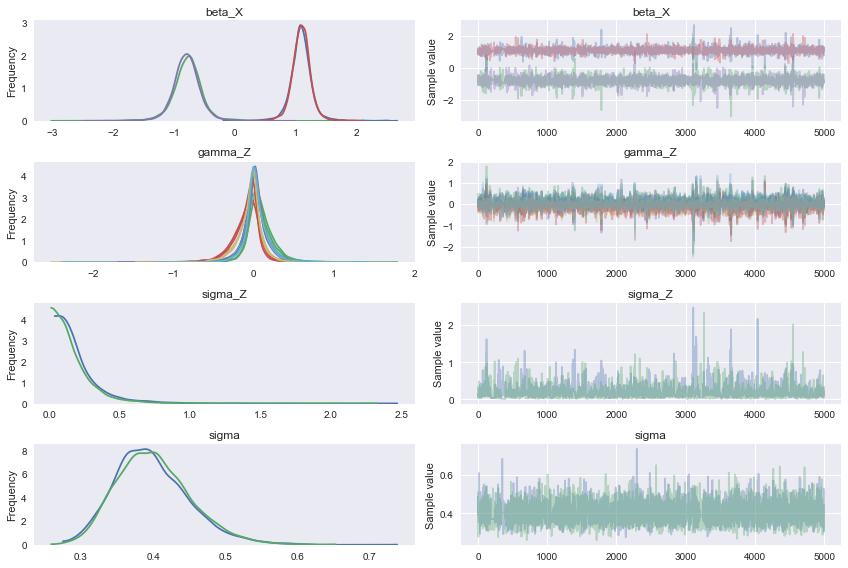

In [12]:
_ = pm.traceplot(trace)

In [13]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_X__0,1.091832,0.177525,0.003004,0.744539,1.419809,2860.0,1.000180
beta_X__1,-0.787883,0.253715,0.005155,-1.260916,-0.313155,2478.0,1.000135
gamma_Z__0,0.018339,0.175174,0.002580,-0.350805,0.361745,3359.0,0.999925
gamma_Z__1,0.078897,0.176224,0.003224,-0.221405,0.459309,2840.0,1.002391
gamma_Z__2,-0.102628,0.185436,0.003519,-0.513085,0.196788,2212.0,1.002260
gamma_Z__3,0.020248,0.175432,0.003245,-0.317701,0.365030,2545.0,0.999917
gamma_Z__4,-0.055668,0.178783,0.003433,-0.443464,0.256153,2631.0,1.000919
gamma_Z__5,0.033621,0.177599,0.003432,-0.303159,0.396100,2346.0,1.000118
sigma_Z,0.187963,0.171778,0.006395,0.013518,0.493230,688.0,1.012195
sigma,0.399963,0.051828,0.000934,0.306813,0.505266,3798.0,1.000850


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C17C08CCF8>,
      dtype=object)

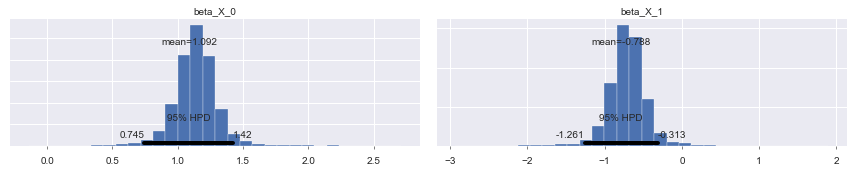

In [14]:
pm.plot_posterior(trace, varnames=['beta_X'])

The `beta_X` seems to be close enough

In [15]:
curdies.groupby(['SEASON'])[['S4DUGES']].mean()

,S4DUGES
SEASON,
WINTER,1.090894
SUMMER,0.304135


The `sigma` seems to be ok

In [16]:
curdies.groupby(['SEASON'])['S4DUGES'].std().mean()

0.3847746117705029

In [17]:
mcmc_X = trace['beta_X']

In [18]:
fit_X = np.dot(np.asarray(mcmc_X), X.T)

In [19]:
fit_X.mean(axis=0)

array([1.09183226, 1.09183226, 1.09183226, 1.09183226, 1.09183226,
       1.09183226, 1.09183226, 1.09183226, 1.09183226, 1.09183226,
       1.09183226, 1.09183226, 1.09183226, 1.09183226, 1.09183226,
       1.09183226, 1.09183226, 1.09183226, 0.30394924, 0.30394924,
       0.30394924, 0.30394924, 0.30394924, 0.30394924, 0.30394924,
       0.30394924, 0.30394924, 0.30394924, 0.30394924, 0.30394924,
       0.30394924, 0.30394924, 0.30394924, 0.30394924, 0.30394924,
       0.30394924])

In [20]:
mcmc_Z = trace['gamma_Z']

In [21]:
fit_Z = np.dot(np.asarray(mcmc_Z), Z.T)

In [22]:
fit_Z.mean(axis=0)

array([ 0.01833868,  0.01833868,  0.01833868,  0.01833868,  0.01833868,
        0.01833868,  0.07889665,  0.07889665,  0.07889665,  0.07889665,
        0.07889665,  0.07889665, -0.10262758, -0.10262758, -0.10262758,
       -0.10262758, -0.10262758, -0.10262758,  0.02024786,  0.02024786,
        0.02024786,  0.02024786,  0.02024786,  0.02024786, -0.05566812,
       -0.05566812, -0.05566812, -0.05566812, -0.05566812, -0.05566812,
        0.0336206 ,  0.0336206 ,  0.0336206 ,  0.0336206 ,  0.0336206 ,
        0.0336206 ])

In [23]:
fit = fit_X + fit_Z

In [24]:
curdies['S4DUGES_FIT'] = fit.mean(axis=0)

In [25]:
curdies

,SEASON,SITE,DUGESIA,S4DUGES,S4DUGES_FIT
0,WINTER,1W,0.647683,0.897100,1.110171
1,WINTER,1W,6.096152,1.571317,1.110171
2,WINTER,1W,1.310564,1.069953,1.110171
3,WINTER,1W,1.725279,1.146080,1.110171
4,WINTER,1W,1.459387,1.099114,1.110171
5,WINTER,1W,1.057561,1.014090,1.110171
6,WINTER,2W,1.016298,1.004050,1.170729
7,WINTER,2W,16.196794,2.006122,1.170729
8,WINTER,2W,1.168081,1.039605,1.170729
9,WINTER,2W,1.024299,1.006020,1.170729


## Alternative parametrization (hierarchical)

In [26]:
X = patsy.dmatrix('SEASON', data=curdies_agg, return_type='dataframe')
X = np.asarray(X)
X # the size should be (n_sites, n_seasons), that is the number of row should be equal to the number of random factors

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 1.],
       [1., 1.],
       [1., 1.]])

In [27]:
with pm.Model() as model:
    
    ## Priors
    # SEASON (2 levels)
    # The values split on season have the same variance (see boxplot above)
    
    # Coefficients for WINTER and SUMMER
    beta_X = pm.Normal('beta_X', mu=0, sd=50, shape=X.shape[1])
    
    estimate_X = pm.math.dot(X, beta_X)
     
    # SITE (6 levels)
    # There are 6 different sites, 3 within SEASON
    sigma_Z = pm.HalfCauchy('sigma_Z', beta=3)
    
    # Centered version
    gamma_Z = pm.Normal('gamma_Z', mu=estimate_X, sd=sigma_Z, shape=Z.shape[1])
    
    # Non Centered version
    #gamma_Z_offset = pm.Normal('gamma_Z_offset', mu=0, sd=1, shape=Z.shape[1])
    #gamma_Z = pm.Deterministic('gamma_Z', gamma_Z_offset * sigma_Z)
    
    estimate_Z = pm.math.dot(Z, gamma_Z)
    
    ## likelihood
    estimate = estimate_Z
    sigma = pm.HalfCauchy('sigma', beta=3) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=estimate, sd=sigma, observed=Y)
    
    trace = pm.sample(draws=5000, chains=2, step=pm.NUTS(), njobs=2, tune=1500)

C:\Miniconda3\envs\GLM_with_PyMC3\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, gamma_Z, sigma_Z_log__, beta_X]
There were 456 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6843658666059772, but should be close to 0.8. Try to increase the number of tuning steps.
There were 403 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


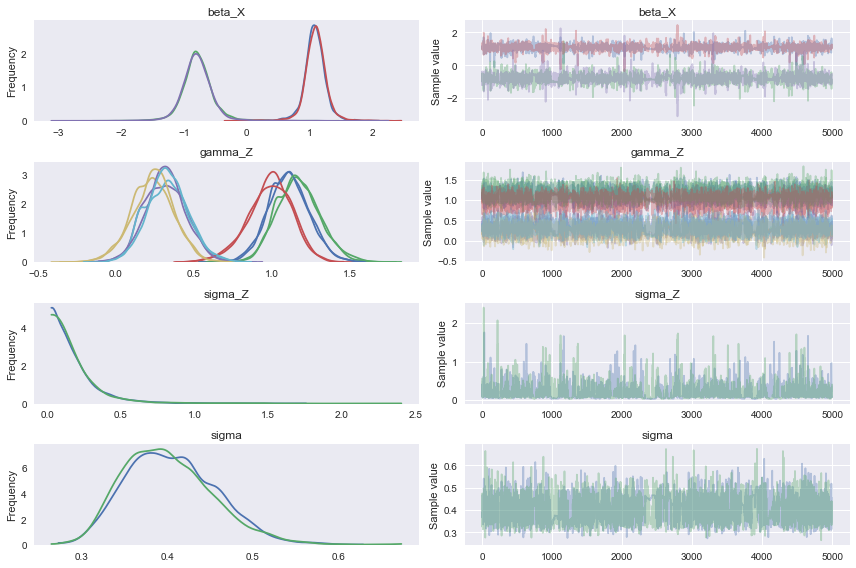

In [28]:
_ = pm.traceplot(trace)

In [29]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_X__0,1.087099,0.182427,0.004447,0.727609,1.433434,1797.0,1.001312
beta_X__1,-0.788454,0.267185,0.006206,-1.264750,-0.281752,1889.0,0.999901
gamma_Z__0,1.109131,0.132147,0.003075,0.852518,1.368906,1612.0,1.001062
gamma_Z__1,1.169547,0.139313,0.003511,0.895949,1.432337,1371.0,1.001149
gamma_Z__2,0.987566,0.144481,0.003307,0.685517,1.256619,1790.0,0.999928
gamma_Z__3,0.317640,0.133024,0.003459,0.068578,0.577643,1280.0,1.000252
gamma_Z__4,0.239183,0.136180,0.003212,-0.039541,0.494671,1942.0,1.000901
gamma_Z__5,0.332465,0.135322,0.003747,0.081663,0.608327,1119.0,1.000771
sigma_Z,0.192136,0.180218,0.005134,0.029139,0.510052,883.0,1.000723
sigma,0.403584,0.052494,0.001292,0.308502,0.503393,1187.0,1.001965


## Standardize values

In [33]:
X = patsy.dmatrix("SEASON", data=curdies, return_type='dataframe')
X = np.asarray(X)

In [34]:
Y = np.asarray(curdies.S4DUGES)
Y

array([0.8970995, 1.5713175, 1.0699526, 1.1460797, 1.0991136, 1.0140897,
       1.0040498, 2.0061216, 1.0396048, 1.0060202, 1.1908882, 1.3845343,
       0.9111253, 1.0507807, 1.0271582, 0.9002881, 0.6074385, 0.7104333,
       0.       , 0.       , 0.9849349, 0.       , 0.       , 1.1199931,
       1.0827734, 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.6037669, 0.       , 0.9006648, 0.7823021])

In [35]:
Y = (Y-Y.mean())/Y.std()
Y

array([ 0.36485678,  1.59738083,  0.68084598,  0.82001236,  0.7341546 ,
        0.57872416,  0.56037042,  2.39223725,  0.62536779,  0.56397247,
        0.90192586,  1.2559263 ,  0.39049706,  0.64579822,  0.60261441,
        0.3706858 , -0.16466653,  0.02361615, -1.27511234, -1.27511234,
        0.52542687, -1.27511234, -1.27511234,  0.77232398,  0.70428342,
       -1.27511234, -1.27511234, -1.27511234, -1.27511234, -1.27511234,
       -1.27511234, -1.27511234, -0.1713785 , -1.27511234,  0.37137443,
        0.15499802])

In [36]:
with pm.Model() as model:
    
    ## Priors
    # SEASON (2 levels)
    # The values split on season have the same variance (see boxplot above)
    
    # Coefficients for WINTER and SUMMER
    beta_X = pm.Normal('beta_X', mu=0, sd=50, shape=X.shape[1])
    
    estimate_X = pm.math.dot(X, beta_X)
     
    # SITE (6 levels)
    # There are 6 different sites, 3 within SEASON
    sigma_Z = pm.HalfCauchy('sigma_Z', beta=3)
    
    # Centered version
    gamma_Z = pm.Normal('gamma_Z', mu=0, sd=sigma_Z, shape=Z.shape[1])
    
    # Non Centered version
    #gamma_Z_offset = pm.Normal('gamma_Z_offset', mu=0, sd=1, shape=Z.shape[1])
    #gamma_Z = pm.Deterministic('gamma_Z', gamma_Z_offset * sigma_Z)
    
    estimate_Z = pm.math.dot(Z, gamma_Z)
    
    ## likelihood
    estimate = estimate_X + estimate_Z
    sigma = pm.HalfCauchy('sigma', beta=3) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=estimate, sd=sigma, observed=Y)
    
    trace = pm.sample(draws=5000, chains=2, step=pm.NUTS(), njobs=2, tune=1500)

C:\Miniconda3\envs\GLM_with_PyMC3\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, gamma_Z, sigma_Z_log__, beta_X]
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


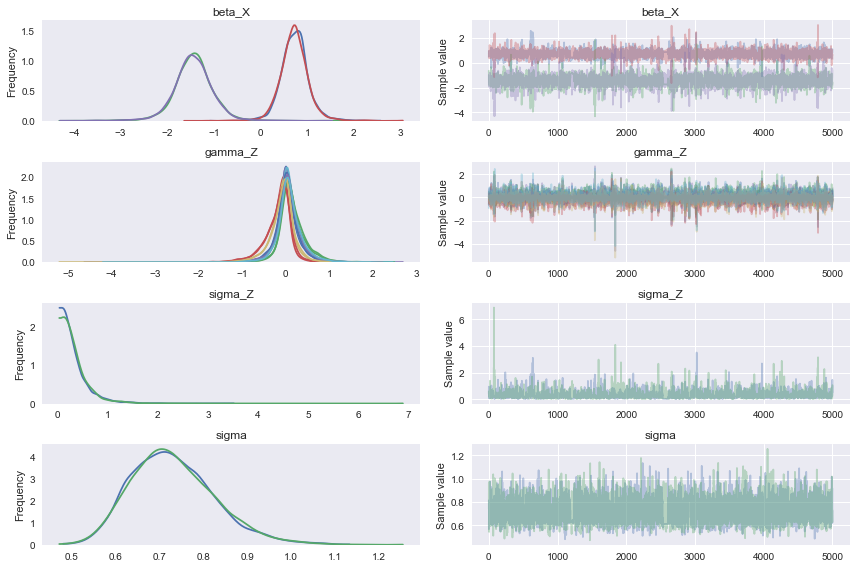

In [37]:
_ = pm.traceplot(trace)

In [38]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_X__0,0.724970,0.310144,0.006283,0.149756,1.342779,2123.0,0.999964
beta_X__1,-1.447537,0.440658,0.008511,-2.297313,-0.610275,2964.0,0.999934
gamma_Z__0,0.024668,0.296083,0.005758,-0.570109,0.628597,3194.0,1.000156
gamma_Z__1,0.140224,0.310929,0.005921,-0.400455,0.859987,2580.0,1.000484
gamma_Z__2,-0.186409,0.321790,0.007136,-0.912717,0.353210,1842.0,0.999911
gamma_Z__3,0.042155,0.298581,0.003721,-0.555017,0.667956,5571.0,1.000013
gamma_Z__4,-0.094929,0.307537,0.004344,-0.729943,0.492139,5238.0,0.999974
gamma_Z__5,0.063920,0.303068,0.003719,-0.479587,0.750398,5438.0,1.000459
sigma_Z,0.333935,0.300615,0.008634,0.036034,0.870286,1120.0,1.000795
sigma,0.731630,0.095146,0.001534,0.561772,0.924762,3776.0,1.000332


## Re-fit after removing missing values from dataset

In [39]:
curdies = pd.read_csv('../datasets/curdies.csv', na_values=0)
curdies.head()

,SEASON,SITE,DUGESIA,S4DUGES
0,WINTER,1,0.647683,0.897100
1,WINTER,1,6.096152,1.571317
2,WINTER,1,1.310564,1.069953
3,WINTER,1,1.725279,1.146080
4,WINTER,1,1.459387,1.099114


In [40]:
curdies.dropna(axis=0, inplace=True)
curdies.reset_index(inplace=True)
curdies.head()

,index,SEASON,SITE,DUGESIA,S4DUGES
0,0,WINTER,1,0.647683,0.897100
1,1,WINTER,1,6.096152,1.571317
2,2,WINTER,1,1.310564,1.069953
3,3,WINTER,1,1.725279,1.146080
4,4,WINTER,1,1.459387,1.099114


In [41]:
curdies['SEASON'] = pd.Categorical(curdies['SEASON'].apply(lambda x: x.strip()), categories=['WINTER', 'SUMMER'], ordered=True)
curdies['SITE'] = pd.Categorical(curdies['SITE'], ordered=False)
curdies['SITE'].cat.rename_categories(labels_SITE, inplace=True)
curdies

,index,SEASON,SITE,DUGESIA,S4DUGES
0,0,WINTER,1W,0.647683,0.897100
1,1,WINTER,1W,6.096152,1.571317
2,2,WINTER,1W,1.310564,1.069953
3,3,WINTER,1W,1.725279,1.146080
4,4,WINTER,1W,1.459387,1.099114
5,5,WINTER,1W,1.057561,1.014090
6,6,WINTER,2W,1.016298,1.004050
7,7,WINTER,2W,16.196794,2.006122
8,8,WINTER,2W,1.168081,1.039605
9,9,WINTER,2W,1.024299,1.006020


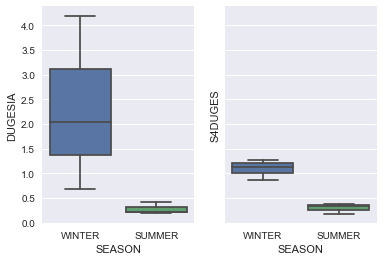

In [42]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)

sns.boxplot(data=curdies_agg, x='SEASON', y='DUGESIA', ax=ax[0]) # variance is non heterogeneous
sns.boxplot(data=curdies_agg, x='SEASON', y='S4DUGES', ax=ax[1]) # the 4th root transformation helps at making the variance heterogeneous

In [43]:
X = patsy.dmatrix("SEASON", data=curdies, return_type='dataframe')
X = np.asarray(X)

In [44]:
# Random effect on the intercepts
Z = patsy.dmatrix('-1 + SITE', data=curdies, return_type='dataframe')
Z = np.asarray(Z)

In [45]:
Y = np.asarray(curdies.S4DUGES)

In [46]:
with pm.Model() as model:
    
    ## Priors
    # SEASON (2 levels)
    # The values split on season have the same variance (see boxplot above)
    sigma_X = pm.HalfCauchy('sigma_X', beta=3)
    # Coefficients for WINTER and SUMMER
    beta_X = pm.Normal('beta_X', mu=0, sd=sigma_X, shape=X.shape[1])
    
    estimate_X = pm.math.dot(X, beta_X)
     
    # SITE (6 levels)
    # There are 6 different sites, 3 within SEASON
    sigma_Z = pm.HalfCauchy('sigma_Z', beta=3)
    
    # Centered version
    gamma_Z = pm.Normal('gamma_Z', mu=0, sd=sigma_Z, shape=Z.shape[1])
    
    # Non Centered version
    #gamma_Z_offset = pm.Normal('gamma_Z_offset', mu=0, sd=1, shape=Z.shape[1])
    #gamma_Z = pm.Deterministic('gamma_Z', gamma_Z_offset * sigma_Z)
    
    estimate_Z = pm.math.dot(Z, gamma_Z)
    
    ## likelihood
    estimate = estimate_X + estimate_Z
    sigma = pm.HalfCauchy('sigma', beta=5) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=estimate, sd=sigma, observed=Y)
    
    trace = pm.sample(draws=5000, chains=4, step=pm.NUTS(), njobs=2, tune=1500)

C:\Miniconda3\envs\GLM_with_PyMC3\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma_log__, gamma_Z, sigma_Z_log__, beta_X, sigma_X_log__]
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.50599902717817, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


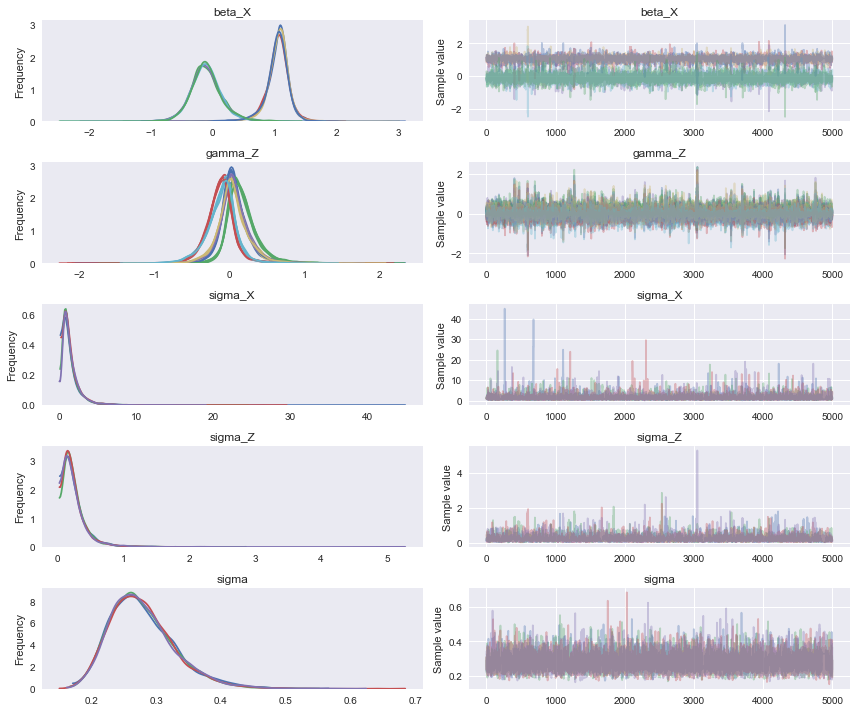

In [47]:
_ = pm.traceplot(trace)

In [48]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_X__0,1.048227,0.196761,0.002663,0.617501,1.382057,4702.0,1.000807
beta_X__1,-0.110027,0.266429,0.003217,-0.611923,0.436107,5424.0,1.000252
gamma_Z__0,0.067320,0.203147,0.002720,-0.292601,0.496960,5092.0,1.000900
gamma_Z__1,0.166018,0.210844,0.003016,-0.213615,0.579839,4307.0,1.000726
gamma_Z__2,-0.119394,0.200886,0.002545,-0.537421,0.242081,5474.0,1.000508
gamma_Z__3,0.057511,0.208914,0.002202,-0.348173,0.486637,8149.0,1.000033
gamma_Z__4,0.055353,0.219007,0.002423,-0.381121,0.499469,7951.0,1.000061
gamma_Z__5,-0.104561,0.207517,0.002402,-0.576843,0.252131,7463.0,0.999988
sigma_X,1.554613,1.489992,0.021530,0.238376,3.862827,5168.0,1.000046
sigma_Z,0.253069,0.196538,0.003549,0.028668,0.596592,2679.0,1.000647
